In [1]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle

from scipy.ndimage import gaussian_filter1d

import corner

import os

import requests

from hyperfit.linfit import LinFit

from desispec.io import read_spectra
from desispec.spectra import stack as specstack
from desispec.coaddition import coadd_cameras

In [2]:
h = 1
H0 = 100*h

c = 3e5

q0 = 0.2

# Data

## fuji

In [3]:
#tfuji = Table.read('/global/project/projectdirs/desi/science/td/pv/desi_pv_tf_fuji_healpix.fits') # <-- CORI
tfuji = Table.read('/global/cfs/projectdirs/desi/science/td/pv/desi_pv_tf_fuji_healpix.fits')
tfuji[:5]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,bytes3,float64,float64,int64,float64,bytes63,bytes3,int64,float64,float64
1079550234591232,194.390863195343,27.5157211790145,10378,sv3,1.1235686466514,7.31685779475115e-05,4,3.28414569795132,fuji/healpix/sv3/bright/103/10378/redrock-sv3-bright-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124544,194.390863195343,27.5157211790145,10378,sv3,0.686773088332363,6.9756676262104e-05,4,0.786607094109058,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124546,194.364461113654,27.5037185881314,10378,sv3,0.0242933923052181,4.95233472646785e-05,0,95.428411073226,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.36446111365385,27.50371858813136
1092744369930240,194.338458724402,27.4918902690326,10378,sv3,0.0264170223697961,0.00010139452689994,0,9.53278421035066,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.33845872440244,27.491890269032595
1092744374124545,194.377858465028,27.5098100780282,10378,sv3,0.211332646769145,6.68535116703737e-05,4,3.73989077657461,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.3778584650283,27.509810078028195


### Separate the fuji data into center and off-center observations

In [4]:
def firstdigit(n):
    """
    Return the first digit of a number.
    
    Parameters
    ----------
    n : int, float, or ndarray
        Number or list of numbers.
    
    Returns
    -------
    digit : int
        First digit of the number.
    """
    
    digit = np.trunc(n * 10**(-np.trunc(np.log10(n)))).astype(int)
    
    return digit

In [5]:
first_digits = firstdigit(tfuji['TARGETID'])

fuji_centers = tfuji[first_digits == 3]
fuji_axis = tfuji[first_digits != 3]

/tmp/ipykernel_5486/917620242.py:16: RuntimeWarning: invalid value encountered in log10
  digit = np.trunc(n * 10**(-np.trunc(np.log10(n)))).astype(int)


### Clean the fuji center observations

Only keep those with
 * DELTACHI2 > 25
 * ZWARN == 0

In [6]:
good_centers = fuji_centers[(fuji_centers['DELTACHI2'] > 25) & (fuji_centers['ZWARN'] == 0)]

#### Are there any galaxies with multiple good center observations?

In [7]:
unique_ids, counts = np.unique(good_centers['SGA_ID'], return_counts=True)

print(unique_ids[counts > 1], counts[counts > 1])

 SGA_ID
-------
    848
   3727
  26199
  37543
  46327
  83216
  98934
 100987
 101569
 102832
    ...
1204188
1244275
1249892
1272144
1273084
1284002
1285273
1319490
1366241
1380792
1382772
Length = 87 rows [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2]


## SGA

In [8]:
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')

SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,

In [9]:
SGA_dict = {}

for i in range(len(SGA)):
    
    SGA_dict[SGA['SGA_ID'][i]] = i

### If an SGA galaxy has at least one observation at its center, set the redshift of that galaxy

In [10]:
SGA['Z_DESI'] = np.nan
SGA['ZERR_DESI'] = np.nan

for sga_id in np.unique(good_centers['SGA_ID']):
    
    # Find the row in SGA for this galaxy
    SGA_idx = SGA_dict[sga_id]
    
    # Set the redshift of this galaxy to be the average redshift of all good center observations
    SGA['Z_DESI'][SGA_idx] = np.mean(good_centers['Z'][good_centers['SGA_ID'] == sga_id])
    SGA['ZERR_DESI'][SGA_idx] = np.mean(good_centers['ZERR'][good_centers['SGA_ID'] == sga_id]**2)/np.sum(good_centers['SGA_ID'] == sga_id)

# Coma cluster membership

Following Cosmicflows4 (Kourkchi et al. 2020), cluster membership is defined as
- $R_p < 1.5R_{2t}$ and $v < V_c \pm 3\sigma_p$
- $1.5R_{2t} \leq R_p < 3R_{2t}$ and $v < V_c \pm 2\sigma_p$

where $R_p$ is the projected distance from the cluster center, $R_{2t}$ is the cluster projected second turnaround radius, $\sigma_p$ is the projected velocity dispersion of the cluster, and $V_c$ is the average heliocentric radial velocity of the cluster.

In [11]:
# Data table #3 from Tully (2015)
hdu = fits.open('../Tully15-Table3.fits')
table3 = Table(hdu[1].data)
hdu.close()

table3[:5]

f_Nest,Nest,Nmb,PGC1,SGLON,SGLAT,logLK,<Vcmba>,DM,sigV,R2t,sigP,Mlum,CF
int16,int32,int16,int32,float64,float64,float64,int32,float64,int16,float64,int16,float64,float64
1,100001,136,44715,89.6226,8.1461,13.15,7331,34.33,886,2.129,1045,1710000000000000.0,1.65
1,100002,197,41220,103.0008,-2.3248,12.69,1491,30.87,670,1.44,707,529000000000000.0,1.0
1,100003,113,43296,156.2336,-11.5868,12.75,3873,32.94,822,1.52,746,623000000000000.0,1.12
1,100004,81,58265,71.5103,49.7851,13.16,9424,34.87,740,2.153,1057,1770000000000000.0,2.26
1,100005,61,36487,92.0255,-10.495,12.78,6987,34.22,707,1.56,766,673000000000000.0,1.58


In [12]:
Coma_nest = 100001

Coma_row_t3 = table3['Nest'] == Coma_nest

R2t_Coma = table3['R2t'][Coma_row_t3][0]
sigma_Coma = table3['sigP'][Coma_row_t3][0]

In [13]:
# Data table #2 from Tully et al. (2013)
hdu = fits.open('../Tully13-Table2.fit')
table2 = Table(hdu[1].data)
hdu.close()

table2[:5]

_RAJ2000,_DEJ2000,N1,__Dist_,__DM_,__Err_,N2,GLON,GLAT,SGLON,SGLAT,GMT,__Bmag_,__Kmag_,__HV_,__GV_,__Vls_,__Vcmb_,__Vcmba_,sigma,__PV_,__PVa_,Group,Ng,_2M__,PGCb,GName,_2M,Simbad,NED,recno
float64,float64,int16,float64,float64,float64,int16,float64,float64,float64,float64,int16,float64,float64,int32,int32,int32,int32,int32,int16,int32,int32,int16,int16,int16,int32,str10,str2,str6,str3,int32
266.404996,-28.936172,16,0.01,14.5,0.02,20,0.0,0.0,185.7861,42.3103,1,-6.0,-9.0,51,26,13,91,91,64,90,90,223,16,0,17223,Galaxy,2M,Simbad,NED,1
15.693346,36.392682,39,0.76,24.4,0.01,41,125.479,-26.423,322.2989,9.4579,2,3.4,0.68,-213,-49,17,-485,-484,156,-541,-547,222,39,0,2557,NGC0224,2M,Simbad,NED,2
149.896678,-12.831016,4,1.37,25.68,0.03,4,251.1365,32.2601,120.502,-42.5472,10,9.75,9.29,347,153,103,690,691,23,589,589,227,4,0,29128,NGC003109,2M,Simbad,NED,3
139.011477,52.840941,1,1.37,25.68,0.1,1,164.6636,42.8855,47.6118,-15.0125,10,13.75,11.5,-29,17,45,130,130,0,28,28,0,579,0,26142,UGC4879,2M,Simbad,NED,4
243.448636,54.37081,1,1.91,26.41,0.08,1,83.8788,44.4092,56.0935,40.37,10,16.69,12.9,-139,44,78,-121,-120,0,-262,-268,230,1,0,2801026,KKR25,2M,Simbad,NED,5


In [14]:
Coma_coords = SkyCoord(table3['SGLON'][Coma_row_t3]*u.degree, 
                       table3['SGLAT'][Coma_row_t3]*u.degree, 
                       frame='supergalactic')

group_coords = SkyCoord(table2['SGLON']*u.degree, 
                        table2['SGLAT']*u.degree, 
                        frame='supergalactic')

idx, d2d, d3d = Coma_coords.match_to_catalog_sky(group_coords)

V_Coma = table2['__HV_'][idx][0]

V_Coma

6899

## Calculate the projected distance between the Coma cluster and each SGA galaxy

In [15]:
# First, we need to convert R2t from Mpc to an angle, using the group's heliocentric velocity
R2t_Coma_angle = (R2t_Coma/(V_Coma/H0))*u.radian

In [16]:
SGA_coords = SkyCoord(SGA['RA'], SGA['DEC'], unit='deg')

sep = Coma_coords.separation(SGA_coords)

In [17]:
SGA_in_Coma1 = (sep < 1.5*R2t_Coma_angle) & (SGA['Z_DESI']*c > V_Coma - 3*sigma_Coma) & (SGA['Z_DESI']*c < V_Coma + 3*sigma_Coma)

SGA_in_Coma2 = (sep >= 1.5*R2t_Coma_angle) & (sep < 3*R2t_Coma_angle) & (SGA['Z_DESI']*c > V_Coma - 2*sigma_Coma) & (SGA['Z_DESI']*c < V_Coma + 2*sigma_Coma)
#SGA_in_Coma2 = (sep >= 1.5*R2t_Coma_angle) & (SGA['Z_DESI']*c > V_Coma - 2*sigma_Coma) & (SGA['Z_DESI']*c < V_Coma + 2*sigma_Coma)

SGA_in_Coma = SGA_in_Coma1 | SGA_in_Coma2

################################################################################
# Keep all observations of each galaxy that are within the Coma cluster
#-------------------------------------------------------------------------------
SGA_ID_in_Coma = SGA['SGA_ID'][SGA_in_Coma]

centers_inComa = good_centers[np.in1d(good_centers['SGA_ID'], SGA_ID_in_Coma)]

axis_inComa = fuji_axis[np.in1d(fuji_axis['SGA_ID'], SGA_ID_in_Coma)]
################################################################################

print('fuji galaxies in Coma with good center observations:', len(np.unique(centers_inComa['SGA_ID'])))
print('fuji off-center observations in Coma:', len(axis_inComa))

fuji galaxies in Coma with good center observations: 272
fuji off-center observations in Coma: 941


In [18]:
Christoph_removed = np.in1d(SGA['SGA_ID'], [309306, 455486, 486394, 1167691, 1269260])

print(SGA_in_Coma1[Christoph_removed])
print(SGA_in_Coma2[Christoph_removed])

[ True False False  True False]
[False  True  True False  True]


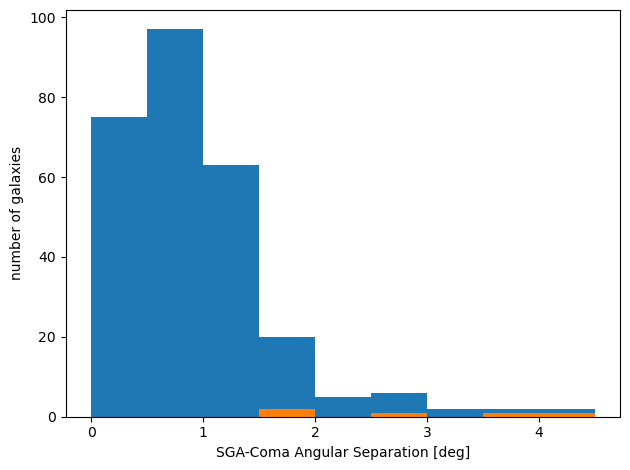

In [19]:
plt.figure(tight_layout=True)

plt.hist(sep[SGA_in_Coma].to_value('degree'), bins=np.arange(0, 5, 0.5))
plt.hist(sep[np.in1d(SGA['SGA_ID'], [309306, 455486, 486394, 1167691, 1269260])].to_value('degree'), bins=np.arange(0, 5, 0.5))

plt.xlabel('SGA-Coma Angular Separation [deg]')
plt.ylabel('number of galaxies');

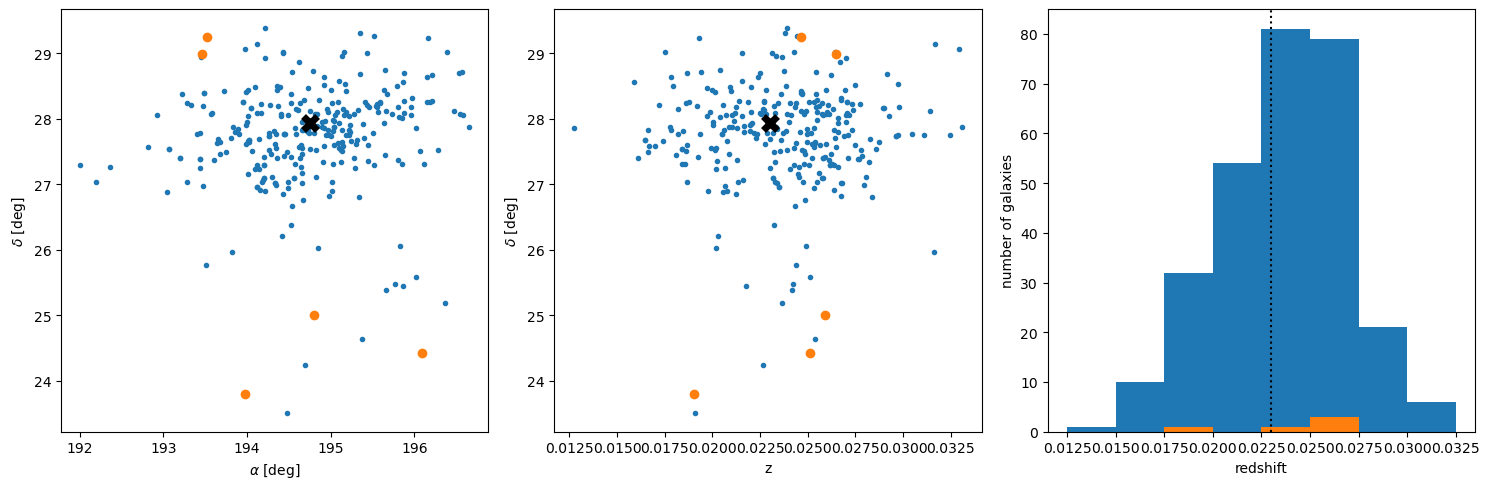

In [20]:
plt.figure(figsize=(15,5), tight_layout=True)

plt.subplot(131)
plt.plot(centers_inComa['TARGET_RA'], centers_inComa['TARGET_DEC'], '.')
plt.plot(centers_inComa['TARGET_RA'][np.in1d(centers_inComa['SGA_ID'], [309306, 455486, 486394, 1167691, 1269260])], 
         centers_inComa['TARGET_DEC'][np.in1d(centers_inComa['SGA_ID'], [309306, 455486, 486394, 1167691, 1269260])],
         'o')
plt.plot(Coma_coords.transform_to('icrs').ra.deg, Coma_coords.transform_to('icrs').dec.deg, 'kx', ms=10, mew=5)
plt.xlabel(r'$\alpha$ [deg]')
plt.ylabel(r'$\delta$ [deg]')

plt.subplot(132)
plt.plot(centers_inComa['Z'], centers_inComa['TARGET_DEC'], '.')
plt.plot(centers_inComa['Z'][np.in1d(centers_inComa['SGA_ID'], [309306, 455486, 486394, 1167691, 1269260])], 
         centers_inComa['TARGET_DEC'][np.in1d(centers_inComa['SGA_ID'], [309306, 455486, 486394, 1167691, 1269260])],
         'o')
plt.plot(V_Coma/c, Coma_coords.transform_to('icrs').dec.deg, 'kx', ms=10, mew=5)
plt.xlabel('z')
plt.ylabel(r'$\delta$ [deg]')

plt.subplot(133)
plt.hist(centers_inComa['Z'], bins=np.arange(0.0125, 0.035, 0.0025))
plt.hist(centers_inComa['Z'][np.in1d(centers_inComa['SGA_ID'], [309306, 455486, 486394, 1167691, 1269260])], bins=np.arange(0.0125, 0.035, 0.0025))
plt.vlines(V_Coma/c, 0, 85, colors='k', linestyles='dotted')
plt.xlabel('redshift')
plt.ylabel('number of galaxies')
plt.ylim(ymax=85);

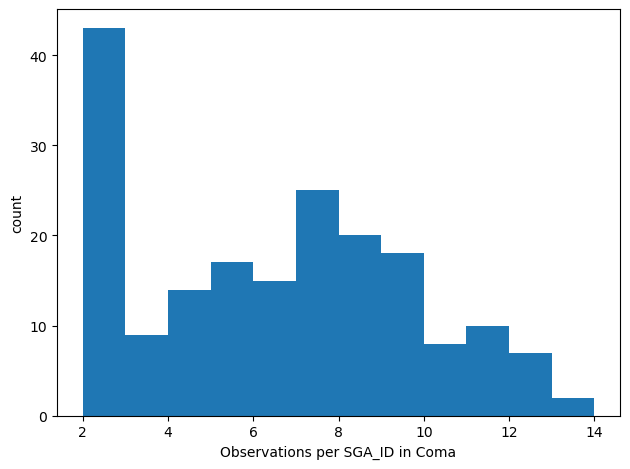

In [21]:
axis_SGAids, axis_counts = np.unique(axis_inComa['SGA_ID'], return_counts=True)
center_SGAids, center_counts = np.unique(centers_inComa['SGA_ID'], return_counts=True)

counts = []

for sga_id in SGA_ID_in_Coma:
    
    center_count = 0
    axis_count = 0
    
    if sga_id in center_SGAids:
        
        center_count = center_counts[center_SGAids == sga_id]
        
    if sga_id in axis_SGAids:
        
        axis_count = axis_counts[axis_SGAids == sga_id]
        
    count = center_count + axis_count
    
    if count > 1:
        
        counts.append(count)
        

plt.figure(tight_layout=True)

plt.hist(np.array(counts), bins=np.arange(2,15))

plt.xlabel('Observations per SGA_ID in Coma')
plt.ylabel('count');

# Calculate the rotational velocity

In [22]:
axis_inComa['SKY_FIBER_DIST'] = 0.
axis_inComa['SKY_FIBER_DIST_R26'] = 0.
axis_inComa['V_ROT'] = np.nan
axis_inComa['V_ROT_ERR'] = np.nan


# For each SGA galaxy that has at least one center observation, calculate the 
# distance for all of that galaxy's targets
for sga_gal in np.unique(centers_inComa['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = axis_inComa['SGA_ID'] == sga_gal
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_gal]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center
    #---------------------------------------------------------------------------
    center_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                             dec=SGA['DEC'][sga_idx], 
                             unit=u.degree)
    target_coords = SkyCoord(ra=axis_inComa['RA'][obs_idx], 
                             dec=axis_inComa['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(center_coords)
    
    axis_inComa['SKY_FIBER_DIST'][obs_idx] = sep2d
    axis_inComa['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Calculate rotational velocity
    #---------------------------------------------------------------------------
    # Use the average redshift of all center observations for the systemic velocity
    z_center = np.mean(SGA['Z_DESI'][sga_idx])
    z_err_center2 = SGA['ZERR_DESI'][sga_idx]**2

    # Calculate rotational velocity for all observations of the galaxy
    axis_inComa['V_ROT'][obs_idx] = c*(axis_inComa['Z'][obs_idx] - z_center)
    axis_inComa['V_ROT_ERR'][obs_idx] = c*np.sqrt(axis_inComa['ZERR'][obs_idx]**2 + z_err_center2)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Correct rotational velocities for inclination angle
    #---------------------------------------------------------------------------
    cosi2 = (SGA['BA'][sga_idx]**2 - q0**2)/(1 - q0**2)
    
    # Galaxies with b/a < q0
    if cosi2 < 0:
        cosi2 = 0
    
    axis_inComa['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    #---------------------------------------------------------------------------

/tmp/ipykernel_5486/2270156695.py:56: RuntimeWarning: divide by zero encountered in true_divide
  axis_inComa['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))


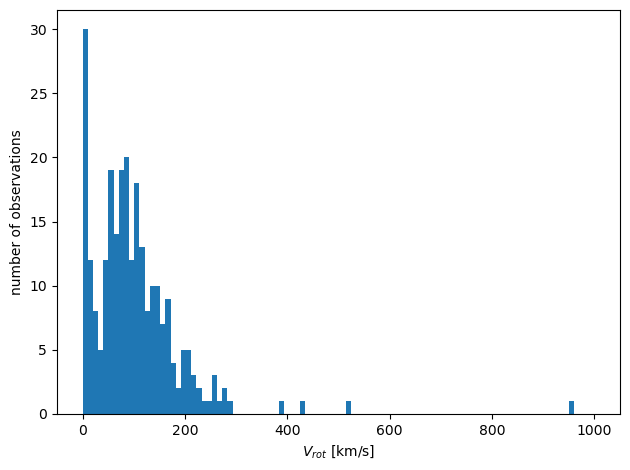

In [23]:
plt.figure(tight_layout=True)

plt.hist(np.abs(axis_inComa['V_ROT']), bins=np.linspace(0, 1000, 100))

plt.xlabel('$V_{rot}$ [km/s]')
plt.ylabel('number of observations');

# Cut for Coma galaxies suitable for calibrating the TFR

Requirements:
 * $V_{rot} < 1000$ km/s at $0.33R_{26}$
 * $i > 45^\circ$
 * Spiral-type morphology
 * Passes visual inspection

## Velocity cut

In [24]:
r0p3 = (axis_inComa['SKY_FIBER_DIST_R26'] > 0.3) & (axis_inComa['SKY_FIBER_DIST_R26'] < 0.4)

Vgood = np.abs(axis_inComa['V_ROT']) < 1000

good_axis_inComa = axis_inComa[r0p3 & Vgood]

print(len(good_axis_inComa), len(np.unique(good_axis_inComa['SGA_ID'])))

198 116


In [26]:
axis_in_Coma = axis_inComa[r0p3]
print(len(axis_in_Coma), len(np.unique(axis_in_Coma['SGA_ID'])))

256 134


In [28]:
bad_axis_inComa = axis_inComa[r0p3 & ~Vgood]

print(len(bad_axis_inComa) , len(np.unique(bad_axis_inComa["SGA_ID"])))

58 42


In [ ]:
bad_axis_inComa